# **Maestría en Inteligencia Artificial Aplicada**

## Curso: **Procesamiento de Lenguaje Natural**

### Tecnológico de Monterrey

### Prof Luis Eduardo Falcón Morales

## Adtividad Semanas 6 y 7

### **Modelado de tópicos - LSI/LDA**

Integrantes:

*   José de Jesús Peña Rodríguez -
*   Gustavo Pérez Juárez -
*   Anghelo Daniel Pérez Martínez - A01795323
*   Rafael Alexis Pinto Flórez -
*   Irene Plascencia Villalobos -

# **Pregunta 1**:
Descarga el archivo noticiasTopicModeling.txt que se encuentra en Canvas. Este archivo consiste en 5658 noticias de varios periódicos de España. El archivo de texto es una lista en el siguiente formato:

[{“titular”:”Encabezado“, “texto”:”Cuerpo”}, ... , {“titular”:”Encabezado”,”texto”:”Cuerpo”}]

Donde “titular” es el encabezado de la noticia y “texto” es el cuerpo del texto de dicha noticia. En particular en esta actividad trabajarás solamente con los cuerpos de las noticias, sin incluir los encabezados. Carga dicho archivo y genera un DataFrame de Pandas llamado “df” y que contiene una única columna llamada “noticia” con 5658 renglones formados por los cuerpos de las noticias.

In [ ]:
!pip install stanza

In [2]:
import pandas as pd
import numpy as np
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import gensim
import gensim.corpora as corpora

from sys import getsizeof
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import stanza
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

In [3]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Colab Notebooks/MNA/Procesamiento del Lenguaje Natural/Semana 6 y 7/')

Mounted at /content/drive


In [4]:
df = pd.read_json("noticiasTopicModeling.txt", encoding_errors='ignore', encoding='latin-1')
df = df.rename(columns={"texto": "noticia"})
df = df.drop("titular", axis=1)

# **Pregunta 2**:
Realiza un proceso de limpieza. Aplica el preprocesamiento que consideres adecuado para texto en español. Recuerda que el objetivo es identificar los tokens (palabras) que describan mejor la distribución de cada tema.
NOTA: Recuerda que esta es una técnica no supervisada, por lo que no requerimos hacer una partición de los datos.

In [5]:
nltk.download('stopwords')
stanza.download('es', verbose=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
additional_stopwords = ["si", "tal", "así", 'él', 'aunque', 'su', 'el', 'sí', 'de',
                        'las', 'una', 'uno', 'la', 'del', 'y', 'con', 'por', 'los',
                        'a', 'le', 'un', 'en', 'esta', 'está', 'como', 'cómo',
                        'pero', 'que', 'qué', 'será', 'haya', 'ha', 'ser', 'pues',
                        'pasó', 'sino', 'sacó', 'hace', 'sigue', 'siguen', 'aún',
                        'uno', 'dos', 'tres', 'cuatro', 'cinco', 'seis','siete',
                        'ocho', 'nueve', 'diez', 'quedó', 'vez', 'algún', 'gran',
                        'cuyo', 'cuyos', 'sacar', 'día', 'ojalá', 'conoce', 'nadie',
                        'ningún', 'tipo', 'toda', 'supuesta', 'puede', 'jamás',
                        'ahí', 'dar', 'menos', 'pp', 'ningún', 'provocó', 'facil',
                        'dejado', 'aquel', 'buena', 'saber', 'cosa', 'nuevo',
                        'sido', 'largo', 'cierto', 'supera', 'pen', 'fp', 'después',
                        'medio', 'incluso', 'se', 'llega', 'lograron', 'deja',
                        'debajo', 'encima', 'abril', 'puntos', 'desempeñar',
                        'pasando', 'decía', 'segunda', 'aprobó', 'dejó', 'parte',
                        'comienzo', 'tener', 'años', 'existía', 'mediados',
                        'domingo', 'lunes','martes', 'miércoles', 'jueves', 'viernes',
                        'sábado', 'precisamente', 'setenta', 'excepcional', 'papel',
                        'excepción', 'cama', 'parecía', 'bebiera', 'beber',
                        'existido', 'nueva', 'nunca', 'ahora', 'apresurado', 'felicitar',
                        'suele', 'quedaron', 'clima',  'consolidación', 'supuestamente',
                        'cancelación', 'través', 'recuperar', 'absoluta', 'encontró',
                        'comenzó', 'apoyo', 'cuadros', 'tercer', 'escalafón',
                        'ejecutivo', 'siguió', 'rompe', 'nueva', 'ahora', 'mejores',
                        'amigos', 'grupo', 'principales', 'referentes', 'ejemplo',
                        'ecr', 'pis', 'apresurado', 'felicitar', 'números', 'últimas',
                        'mes', 'amplio', 'suele', 'situar', 'fidesz', 'suspendidos',
                        'grupo', 'mayo', 'pasado', 'efecto', 'escalón', 'subcampeones',
                        'quedaron', 'generales', 'septiembre', 'duplica', 'sumaron',
                        'solución', 'dorada', 'julio', 'pasado', 'décimas', 'supuestamente',
                        'llevado', 'suma', 'recuerda', 'vivida', 'primero',
                        'respectivamente', 'ponen', 'podemos', 'maneras', 'hacer',
                        'querer', 'el', 'tras']
mystopwords = stopwords.words("spanish") + additional_stopwords

In [7]:
lem = stanza.Pipeline('es', verbose=False)

In [8]:
def construir_vocabulario_basico(original_df):
  temp_list = []

  for index, row in original_df.iterrows():
    # separar noticia en palabras minúsculas
    palabras = row['noticia'].strip().lower().split(" ")
    for w in palabras:
      # eliminar caracteres especiales
      w = re.sub('[^a-zñáéíóú]', "", w)
      # eliminar stopwords, espacios y palabras de longitud 1
      if w not in mystopwords and w != "" and len(w) > 1:
        temp_list.append(w)
  return temp_list

In [9]:
vocabulary = construir_vocabulario_basico(df)

In [10]:
# contar la frecuancia de cada palabra
def count_words(vocab):
  count = dict()

  for w in vocabulary:
    if w in count:
      count[w] += 1
    else:
      count.update({w: 1})
  return count

word_count = count_words(vocabulary)

In [19]:
# filtrar palabras por su frecuencia en el vocabulario, máximos y mínimos
def filter_vocab_by_freq(vocab, word_count):
  temp_list = []
  for w in vocab:
    if w in word_count:
      if word_count[w] >= 50:
        temp_list.append(w)
  return temp_list

In [20]:
vocabulary = filter_vocab_by_freq(vocabulary, word_count)

In [21]:
vocabulary = list(dict.fromkeys(vocabulary))

In [23]:
docs = []

# Procesar noticias, eliminar caracteres especiales y filtrar sus palabras
# por las incluidas en el vocabulario
for index, row in df.iterrows():
  palabras = row['noticia'].strip().lower().split(" ")
  noticia_temp = [re.sub('[^a-zñáéíóú]', "", w) for w in palabras if w != '' and w in vocabulary]
  noticia = []
  for w in noticia_temp:
    noticia.append(w)
  docs.append(noticia)


In [24]:
dtm = []

for doc in docs:
    tmp = ' '.join(doc)
    dtm.append(tmp)

# **Parte 1: Indexación semántica latente (LSI):**

# **Pregunta 3**:
Encontrar la matriz Tf-idf de la columna de noticias. Despliega los primeros 5 renglones con algunas de sus columnas con sus nombres, donde las columnas son los tokens.

### **¿Cuál es el significado de cada renglón? ¿Y el significado de cada columna?**
Cada renglón representa una noticia, y cada columna uno de los terminos o palabras, el valor numérico nos indica la importancia de la palabra en la noticia.

In [25]:
tfidf = TfidfVectorizer()
tfidf_sparse = tfidf.fit_transform(dtm)

In [26]:
tfidf_dense = pd.DataFrame(tfidf_sparse.toarray(), columns=tfidf.get_feature_names_out())
tfidf_dense.head()

,abajo,abandonado,abandonar,abandono,abandonó,abascal,abc,abdicación,abertzale,abierta,...,última,último,últimos,única,únicamente,únicas,único,únicos,útil,útiles
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.043341,0.0,0.0,0.0,0.0,...,0.021604,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.025352,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# **Pregunta 4**:
Aplica el método de descomposición de valores singulares truncado a la matriz Tf-idf anterior con 10 componentes y obtener el gráfico de la importancia relativa de estas.

In [27]:
lsi_obj = TruncatedSVD(n_components = 10, n_iter=120, random_state=33)
tfidf_lsi = lsi_obj.fit_transform(tfidf_sparse)
Sigma = lsi_obj.singular_values_
V_T = lsi_obj.components_.T

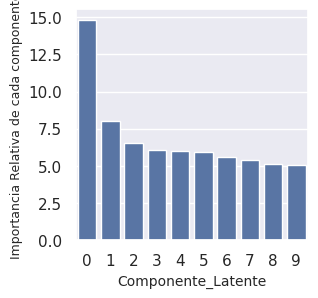

In [28]:
sns.set(rc={'figure.figsize':(3,3)})
chart = sns.barplot(x=list(range(len(Sigma))), y = Sigma )
chart.set_xlabel('Componente_Latente', fontdict={'size': 10})
chart.set_ylabel('Importancia Relativa de cada componente', fontdict={'size': 9})
plt.show()

# **Pregunta 5**:
Obtener la matriz tokens-temas (term-topic) a partir de la matriz V
T de la descomposición SVD. Despliega sus primeros 5 renglones donde se incluya el nombre de las columnas.

In [29]:
lsi_term_topic = V_T
term_names = list(tfidf.get_feature_names_out())
term_topic_matrix = pd.DataFrame(data=lsi_term_topic, index = term_names,
            columns = [f'Concepto_Latente_{r+1}' for r in range(0,V_T.shape[1])])

In [30]:
term_topic_matrix[0:5]

,Concepto_Latente_1,Concepto_Latente_2,Concepto_Latente_3,Concepto_Latente_4,Concepto_Latente_5,Concepto_Latente_6,Concepto_Latente_7,Concepto_Latente_8,Concepto_Latente_9,Concepto_Latente_10
abajo,0.002763,-0.001194,-0.005260,0.002610,0.000480,0.000995,-0.002016,0.000879,0.000966,-0.002305
abandonado,0.003172,-0.002314,0.000190,-0.002505,-0.001748,-0.000636,-0.002594,0.001608,0.000340,-0.003896
abandonar,0.007600,-0.005363,-0.006014,0.000902,-0.003605,0.001264,-0.002806,-0.000127,-0.000223,-0.000018
abandono,0.004046,-0.000326,-0.004253,-0.003160,0.000007,-0.001551,-0.001376,-0.000586,0.002592,-0.002241
abandonó,0.003934,-0.005410,0.001924,0.001635,-0.003026,0.001324,-0.003502,0.001139,0.002140,0.001005


# **Pregunta 6**:
Con base a la cantidad de conceptos latentes que determinaste en el ejercicio anterior, obtener cada uno de sus gráficos con sus 10 términos/tokens más importantes. ¿Cómo describirías cada uno de dichos conceptos latentes? ¿Se identifican claramente las temáticas de cada uno de ellos?

In [31]:
def graficar_terminos_concepto_latente(numero_columna, numero_terminos):
  data = term_topic_matrix[f'Concepto_Latente_' + str(numero_columna)]
  data = data.sort_values(ascending=False)
  top_w_matrix = data[:numero_terminos]
  sns.set(rc={'figure.figsize':(3,2)})
  plt.title('Mejores términos/tokens del Concepto-Latente-' + str(numero_columna))
  fig = sns.barplot(x= top_w_matrix.values, y=top_w_matrix.index)

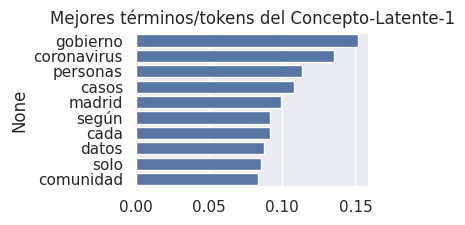

In [32]:
graficar_terminos_concepto_latente(1, 10)

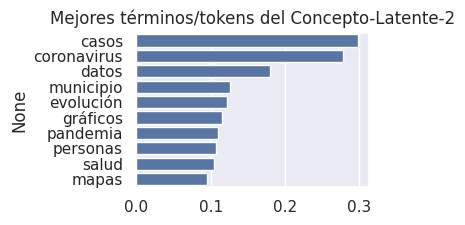

In [33]:
graficar_terminos_concepto_latente(2, 10)

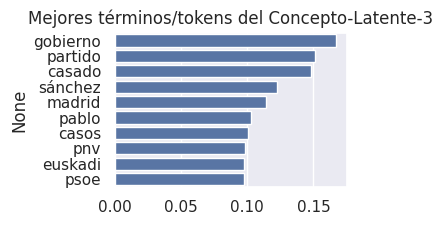

In [34]:
graficar_terminos_concepto_latente(3, 10)

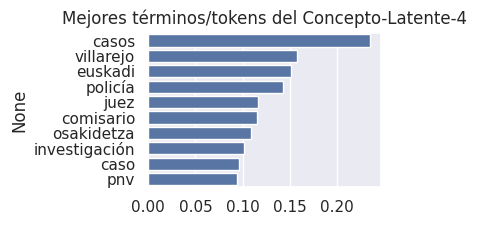

In [35]:
graficar_terminos_concepto_latente(4, 10)

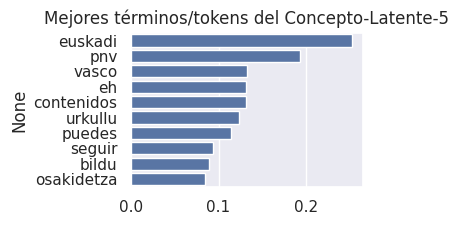

In [36]:
graficar_terminos_concepto_latente(5, 10)

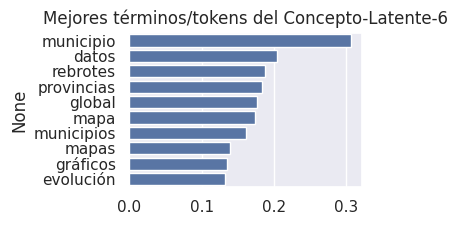

In [37]:
graficar_terminos_concepto_latente(6, 10)

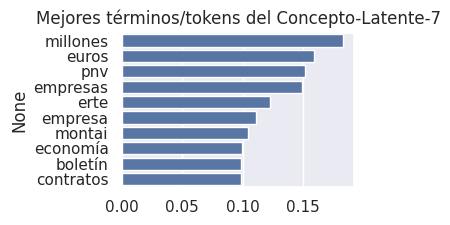

In [38]:
graficar_terminos_concepto_latente(7, 10)

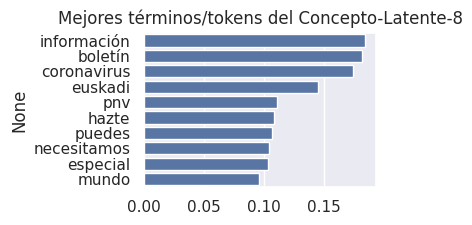

In [39]:
graficar_terminos_concepto_latente(8, 10)

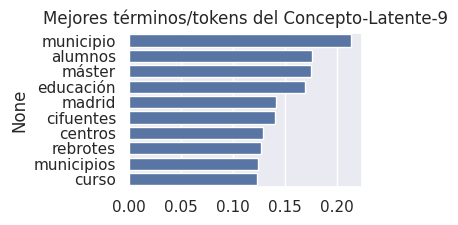

In [40]:
graficar_terminos_concepto_latente(9, 10)

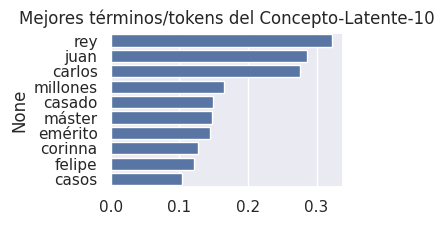

In [41]:
graficar_terminos_concepto_latente(10, 10)

# **Parte 2: Asignación de Dirichlet Latente (LDA):**

# **Pregunta 7**:
Utiliza la librería Gensim para implementar ahora la técnica de LDA. Revisa la documentación correspondiente y aplica de preferencia el modelo paralelizable:
https://radimrehurek.com/gensim/models/ldamodel.html
https://radimrehurek.com/gensim/models/ldamulticore.html

In [42]:
id2word = corpora.Dictionary(docs)

In [43]:
corpus = [id2word.doc2bow(doc) for doc in docs]

In [44]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                    id2word=id2word,
                    num_topics=10,      # total de tópicos que deseas buscar...
                    chunksize=20,    # número de documentos a analizar en cada chunk de entrenamiento
                    passes=10,        # número de pasadas al corpus durante el entrenamiento.
                    alpha=0.2,        # alfa: similaridad document-topics
                    eta=0.2,         # beta: similaridad topic-words
                    )

In [45]:
lda_model.print_topics(num_topics=10, num_words=10)

[(0,
  '0.056*"madrid" + 0.029*"comunidad" + 0.021*"gobierno" + 0.018*"presidenta" + 0.016*"ayuso" + 0.013*"díaz" + 0.013*"isabel" + 0.011*"ayuntamiento" + 0.010*"regional" + 0.010*"consejero"'),
 (1,
  '0.026*"gobierno" + 0.015*"partido" + 0.013*"política" + 0.010*"presidente" + 0.010*"sánchez" + 0.008*"casado" + 0.008*"líder" + 0.008*"psoe" + 0.007*"pablo" + 0.007*"portavoz"'),
 (2,
  '0.011*"según" + 0.009*"ciudad" + 0.008*"etiquetas" + 0.008*"personas" + 0.007*"san" + 0.007*"capital" + 0.006*"zona" + 0.005*"año" + 0.005*"centro" + 0.005*"horas"'),
 (3,
  '0.017*"the" + 0.016*"guerra" + 0.011*"país" + 0.010*"reino" + 0.009*"dijo" + 0.009*"unidos" + 0.008*"internacional" + 0.008*"dólares" + 0.007*"trump" + 0.007*"presidente"'),
 (4,
  '0.026*"millones" + 0.016*"empresas" + 0.015*"euros" + 0.013*"empresa" + 0.009*"economía" + 0.008*"según" + 0.008*"año" + 0.008*"gobierno" + 0.007*"trabajadores" + 0.006*"erte"'),
 (5,
  '0.035*"casos" + 0.019*"personas" + 0.018*"datos" + 0.014*"cada" +

# **Pregunta 8**:
Con base a esta técnica ¿qué cantidad de tópicos consideras que es la más adecuada? Compara tus resultados con el método LSI. ¿Qué encuentras de coincidencias y diferencias? ¿Cuál consideras puede ser el mejor resultado, es decir, cuál consideras puede ser la mejor cantidad de tópicos a considerar?

# **Pregunta 9**:
Incluye tus conclusiones finales de la actividad.